Read the csv in from Lab2

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('dataForLab2.csv')

Inspect the data

In [3]:
df[:5]

,Unnamed: 0,ENTITY,ACTUAL YEAR,RECORDS LOST,ORGANISATION,METHOD OF LEAK,DATA SENSITIVITY
0,0,AOL,2004,92000000,web,inside job,1
1,1,Automatic Data Processing,2005,125000,financial,poor security,20
2,2,Ameritrade Inc.,2005,200000,financial,lost / stolen device,20
3,3,Citigroup,2005,3900000,financial,lost / stolen device,300
4,4,Cardsystems Solutions Inc.,2005,40000000,financial,hacked,300


Drop first row

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df[:5]

,ENTITY,ACTUAL YEAR,RECORDS LOST,ORGANISATION,METHOD OF LEAK,DATA SENSITIVITY
0,AOL,2004,92000000,web,inside job,1
1,Automatic Data Processing,2005,125000,financial,poor security,20
2,Ameritrade Inc.,2005,200000,financial,lost / stolen device,20
3,Citigroup,2005,3900000,financial,lost / stolen device,300
4,Cardsystems Solutions Inc.,2005,40000000,financial,hacked,300


Extract the Entity column 

In [6]:
entities = df['ENTITY'] 

Find out the one with higer number breaches

In [7]:
entities.value_counts()[:10]

Yahoo                         3
AOL                           3
Citigroup                     3
Dropbox                       2
US Military                   2
Countrywide Financial Corp    2
AT&T                          2
JP Morgan Chase               2
Sony Pictures                 2
Interpark                     1
Name: ENTITY, dtype: int64

Find out which years the breaches happened

In [8]:
df.index = entities
df.loc['Citigroup',:]

,ENTITY,ACTUAL YEAR,RECORDS LOST,ORGANISATION,METHOD OF LEAK,DATA SENSITIVITY
ENTITY,,,,,,
Citigroup,Citigroup,2005,3900000,financial,lost / stolen device,300
Citigroup,Citigroup,2011,360083,financial,hacked,300
Citigroup,Citigroup,2013,150000,financial,accidentally published,20


### Query this ticker symbol for 'Citigroup' since it has three breches

In [9]:
import json 
from urllib2 import urlopen

Get Json Responses for all entities

In [13]:
def getSymbols(name):
    response = urlopen("http://d.yimg.com/autoc.finance.yahoo.com/autoc?query="+'%20'.join(name.split(' '))+"&region=1&lang=en").read().decode('utf-8')
    responseJson = json.loads(response)
    return responseJson
    

In [14]:
responseJson = getSymbols('Citigroup')

In [15]:
info = responseJson.get('ResultSet').get('Result')

Get the results function

In [22]:
info[2]

{u'exch': u'NYQ',
 u'exchDisp': u'NYSE',
 u'name': u'Citigroup Capital XIII',
 u'symbol': u'C-PN',
 u'type': u'S',
 u'typeDisp': u'Equity'}

Extract symbols and names then store in a dic
#### Criteria: IPO in NYSE or NASDAQ and typeDisp is Equity

Get symbols and names function

Use fuzzy wuzzy to find the most possible one

In [17]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

Use function to extract all names to compare with entities later

In [42]:
symbolsAndNames = {}
for item in info:
    if (item.get('exchDisp') == 'NYSE') and(item.get('typeDisp') == 'Equity') or (item.get('exchDisp') == 'NASDAQ') and(item.get('typeDisp') == 'Equity'):
        key  = item.get('symbol')
        value = item.get('name')
        symbolsAndNames[key] = value

In [43]:
symbolsAndNames

{u'C': u'Citigroup Inc.',
 u'C-PC': u'Citigroup Inc.',
 u'C-PJ': u'Citigroup Inc.',
 u'C-PK': u'Citigroup Inc. Dep Shs Repstg 1',
 u'C-PL': u'Citigroup Inc.',
 u'C-PN': u'Citigroup Capital XIII',
 u'C-PP': u'Citigroup Inc.',
 u'C-PS': u'Citigroup Inc.'}

In [25]:
names = []
for v in symbolsAndNames.values():
    names.append(v)

In [26]:
names

[u'Citigroup Inc.',
 u'Citigroup Inc.',
 u'Citigroup Inc.',
 u'Citigroup Inc.',
 u'Citigroup Inc.',
 u'Citigroup Inc. Dep Shs Repstg 1',
 u'Citigroup Inc.',
 u'Citigroup Capital XIII']

Fuzzy Wuzzy Process Function

In [27]:
scoresList = process.extract('Citigroup',names)

In [28]:
scoresList 

[(u'Citigroup Inc.', 95),
 (u'Citigroup Inc.', 95),
 (u'Citigroup Inc.', 95),
 (u'Citigroup Inc.', 95),
 (u'Citigroup Inc.', 95)]

In [29]:
nameHasMaxScore = str(scoresList[0][0]) # First one always has the highest score

In [30]:
nameHasMaxScore

'Citigroup Inc.'

Get the higest score one

Look up symbols has the name with highest fuzzy wuzzy score and store it in a list

In [33]:
symbols = []
for symbol, name in symbolsAndNames.items() :
    if name == nameHasMaxScore:
        symbols.append(str(symbol))

These are the symbols corresonponding the names after fuzzy wuzzy

In [34]:
symbols

['C-PP', 'C', 'C-PS', 'C-PC', 'C-PJ', 'C-PL']

Remove anything after dash and Settle down to a finalized symbol list

In [35]:
import re

In [36]:
symbolsFinal = []
for symbol in symbols:
    if '-' in symbol:
        symbolsFinal.append(re.sub('-[A-Z]+', '', symbol))
    else :
        symbolsFinal.append(symbol)

In [37]:
symbolsFinal

['C', 'C', 'C', 'C', 'C', 'C']

Extract the first one as the finalized ticker symbol

In [38]:
finalSymbol = symbolsFinal[0]

In [39]:
finalSymbol

'C'

Use pandas_reader to get historical data for ticker symbol C

In [29]:
from pandas_datareader import data as pdr

In [36]:
panel_data = pdr.DataReader('C', 'yahoo', "2005-01-01", "2015-10-06")

In [37]:
panel_data.columns

Index([u'Open', u'High', u'Low', u'Close', u'Adj Close', u'Volume'], dtype='object')

Extract the closing price

In [38]:
closePrice = panel_data['Close']

In [41]:
closePrice.index.name = 'Date'

In [43]:
closePrice.columns = ['Close Price']

In [40]:
closePrice[:10]

NameError: name 'closePrice' is not defined

Drew the plot to get a idea 

In [39]:
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


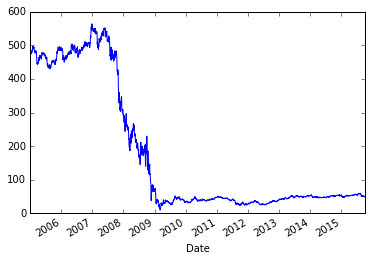

In [40]:
%pylab inline
closePrice.plot()

save the data to csv file

In [45]:
closePrice.to_csv('closePrice.csv')